<a href="https://colab.research.google.com/github/Oebele/Deep-lerning-for-beginners/blob/master/Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks
## Training a Generative Adversarial Network
### An MLP model

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

img_dims = 28
img_chnl = 1 
ltnt_dim = 100

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# this makes sure that each image has a third dimension
x_train = np.expand_dims(x_train, axis=3)    # 28x28x1
x_test = np.expand_dims(x_test, axis=3)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# building the generator network
inpt_noise = Input(shape=(ltnt_dim,))
gl1 = Dense(256, activation='relu')(inpt_noise)
gl2 = BatchNormalization()(gl1)
gl3 = Dense(512, activation='relu')(gl2)
gl4 = BatchNormalization()(gl3)
gl5 = Dense(1024, activation='relu')(gl4)
gl6 = BatchNormalization()(gl5)
gl7 = Dropout(0.5)(gl6)
gl8= Dense(img_dims*img_dims*img_chnl, activation='sigmoid')(gl7)
gl9= Reshape((img_dims,img_dims,img_chnl))(gl8)
generator = Model(inpt_noise, gl9)
gnrtr_img = generator(inpt_noise)
# uncomment this if you want to see the summary
# generator.summary()

# building the discriminator network
inpt_img = Input(shape=(img_dims,img_dims,img_chnl))
dl1 = Flatten()(inpt_img)
dl2 = Dropout(0.5)(dl1)
dl3 = Dense(512, activation='relu')(dl2)
dl4 = Dense(256, activation='relu')(dl3)
dl5 = Dense(1, activation='sigmoid')(dl4)
discriminator = Model(inpt_img, dl5)
validity = discriminator(gnrtr_img)
# uncomment this if you want to see the summary
# discriminator.summary()

# you can use either optimizer:
# optimizer = RMSprop(0.0005)
optimizer = Adam(0.0002, 0.5)

# compiling the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, 
                      metrics=['accuracy'])

# this will freeze the discriminator in gen_dis below
discriminator.trainable = False

gen_dis = Model(inpt_noise, validity)    # full model
gen_dis.compile(loss='binary_crossentropy', optimizer=optimizer)


epochs = 12001     # this is up to you!
batch_size=128    # small batches recommended
sample_interval=400    # for generating samples

# target vectors
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# we will need these for plots and generated images
samp_imgs = {}
dloss = []
gloss = []
dacc = []

# this loop will train in batches manually for every epoch
for epoch in range(epochs):
  # training the discriminator first >>
  # batch of valid images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]
  
  # noise batch to generate fake images
  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))
  gen_imgs = generator.predict(noise)

  # gradient descent on the batch
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # next we train the generator with the discriminator frozen >>
  # noise batch to generate fake images
  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))

  # gradient descent on the batch
  g_loss = gen_dis.train_on_batch(noise, valid)
  
  # save performance
  dloss.append(d_loss[0])
  dacc.append(d_loss[1])
  gloss.append(g_loss)

  # print performance every sampling interval
  if epoch % sample_interval == 0:
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # use noise to generate some images
    noise = np.random.uniform(0, 1, (2, ltnt_dim))
    gen_imgs = generator.predict(noise)
    samp_imgs[epoch] = gen_imgs


11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
0 [D loss: 0.837445, acc.: 42.19%] [G loss: 0.770716]
400 [D loss: 0.270114, acc.: 92.58%] [G loss: 8.201605]
800 [D loss: 0.157477, acc.: 94.14%] [G loss: 6.257805]
1200 [D loss: 0.350101, acc.: 83.98%] [G loss: 2.681375]
1600 [D loss: 0.463075, acc.: 82.03%] [G loss: 2.605392]
2000 [D loss: 0.371416, acc.: 85.55%] [G loss: 2.046624]
2400 [D loss: 0.388857, acc.: 83.20%] [G loss: 1.979222]
2800 [D loss: 0.405914, acc.: 82.42%] [G loss: 1.878976]
3200 [D loss: 0.446033, acc.: 81.25%] [G loss: 1.667467]
3600 [D loss: 0.411755, acc.: 80.47%] [G loss: 1.738543]
4000 [D loss: 0.487296, acc.: 79.30%] [G loss: 1.589137]
4400 [D loss: 0.485168, acc.: 78.12%] [G loss: 1.425256]
4800 [D loss: 0.520181, acc.: 74.61%] [G loss: 1.410120]
5200 [D loss: 0.522166, acc.: 75.00%] [G loss: 1.395756]
5600 [D loss: 0.520141, acc.: 71.09%] [G loss: 1.240330]
6000 [D loss: 0.59

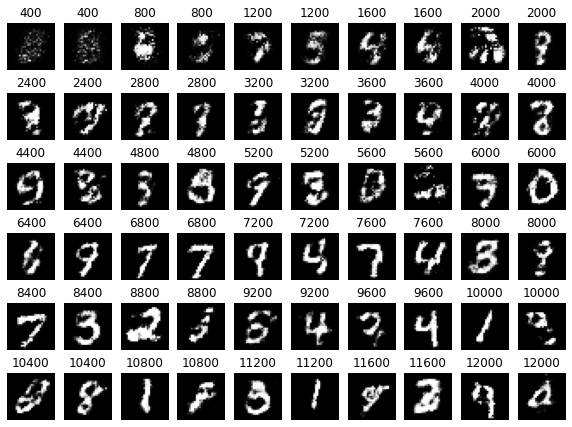

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 10, figsize=(10,7.5))
cnt = sample_interval
for i in range(6):
  for j in [0, 2, 4, 6, 8]:
    img = samp_imgs[cnt]
    axs[i,j].imshow(img[0,:,:,0], cmap='gray')
    axs[i,j].axis('off')
    axs[i,j].set_title(cnt)
    axs[i,j+1].imshow(img[1,:,:,0], cmap='gray')
    axs[i,j+1].axis('off')
    axs[i,j+1].set_title(cnt)
    cnt += sample_interval
# ?plt.savefig('ch.14.gan.mnist.generated.png', dpi=350, bbox_inches='tight')
plt.show()

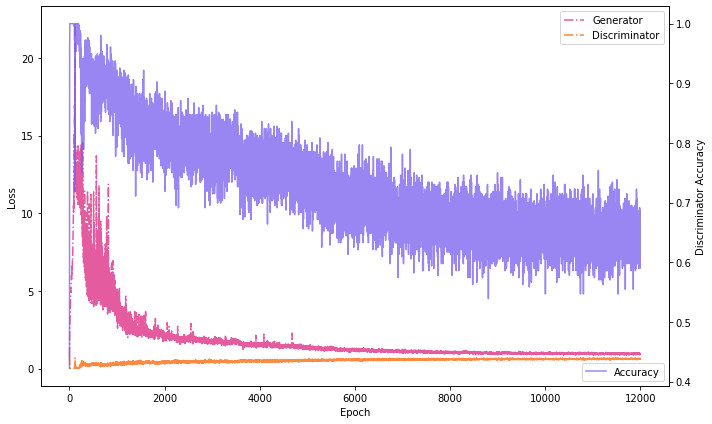

In [3]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(epochs), gloss, '-.', color='#dc267f', alpha=0.75, label='Generator')
ax1.plot(range(epochs), dloss, '-.', color='#fe6100', alpha=0.75, label='Discriminator')
ax1.legend(loc=1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Discriminator Accuracy')  # we already handled the x-label with ax1
ax2.plot(range(epochs), dacc, color='#785ef0', alpha=0.75, label='Accuracy')
ax2.legend(loc=4)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('ch.14.gan.mnist.loss.png', dpi=350, bbox_inches='tight')
plt.show()


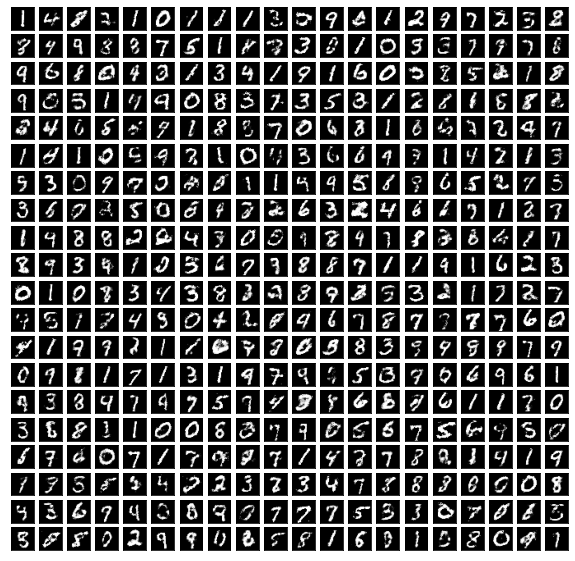

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
samples = np.random.uniform(0.0, 1.0, size=(400,ltnt_dim))
imgs = generator.predict(samples)
for cnt in range(20*20):
  plt.subplot(20,20,cnt+1)
  img = imgs[cnt]
  plt.imshow(img[:,:,0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
# plt.savefig('ch.14.gan.mnist.latent.png', bbox_inches='tight', dpi=350)
plt.show()


## A convolutional model

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input, Conv2DTranspose, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

img_dims = 28
img_chnl = 1 
ltnt_dim = 100

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# building the generator convolutional network
inpt_noise = Input(shape=(ltnt_dim,))
gl1 = Dense(7*7*256, activation='relu')(inpt_noise)
gl2 = BatchNormalization()(gl1)
gl3 = Reshape((7, 7, 256))(gl2)
gl4 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu')(gl3)
gl5 = BatchNormalization()(gl4)
gl6 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(gl5)
gl7 = BatchNormalization()(gl6)
gl8 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')(gl7)
generator = Model(inpt_noise, gl8)
gnrtr_img = generator(inpt_noise)
generator.summary()  # print to verify dimensions

# building the critic convolutional network
inpt_img = Input(shape=(img_dims,img_dims,img_chnl))
dl1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(inpt_img)
dl2 = Dropout(0.3)(dl1)
dl3 = Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(dl2)
dl4 = Dropout(0.3)(dl3)
dl5 = Flatten()(dl4)
dl6 = Dense(1, activation='sigmoid')(dl5)
critic = Model(inpt_img, dl6)
validity = critic(gnrtr_img)
critic.summary()   # again, print for verification

optimizer = Adam(0.0002, 0.5)

critic.compile(loss='binary_crossentropy', optimizer=optimizer, 
               metrics=['accuracy'])

critic.trainable = False

gen_crt = Model(inpt_noise, validity)
gen_crt.compile(loss='binary_crossentropy', optimizer=optimizer)

epochs = 12001
batch_size=64
sample_interval=400

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

samp_imgs = {}
closs = []
gloss = []
cacc = []
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))
  gen_imgs = generator.predict(noise)
  c_loss_real = critic.train_on_batch(imgs, valid)
  c_loss_fake = critic.train_on_batch(gen_imgs, fake)
  c_loss = 0.5 * np.add(c_loss_real, c_loss_fake)

  noise = np.random.uniform(0, 1, (batch_size, ltnt_dim))
  g_loss = gen_crt.train_on_batch(noise, valid)
  
  closs.append(c_loss[0])
  cacc.append(c_loss[1])
  gloss.append(g_loss)

  if epoch % sample_interval == 0:
    print ("%d [C loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
  
    noise = np.random.uniform(0, 1, (2, ltnt_dim))
    gen_imgs = generator.predict(noise)
    samp_imgs[epoch] = gen_imgs


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)       

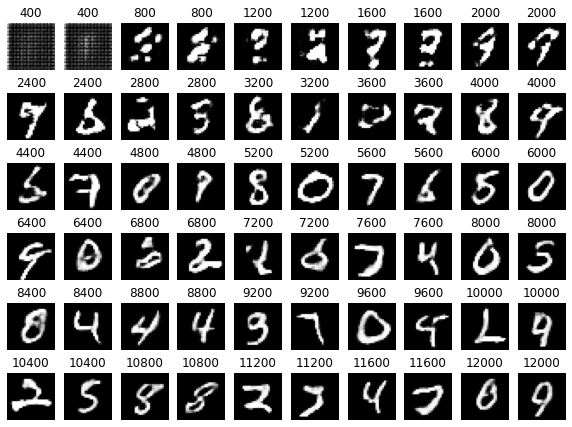

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 10, figsize=(10,7.5))
cnt = sample_interval
for i in range(6):
  for j in [0, 2, 4, 6, 8]:
    img = samp_imgs[cnt]
    axs[i,j].imshow(img[0,:,:,0], cmap='gray')
    axs[i,j].axis('off')
    axs[i,j].set_title(cnt)
    axs[i,j+1].imshow(img[1,:,:,0], cmap='gray')
    axs[i,j+1].axis('off')
    axs[i,j+1].set_title(cnt)
    cnt += sample_interval
# plt.savefig('ch.14.gan.cnn.mnist.generated.png', dpi=350, bbox_inches='tight')
plt.show()

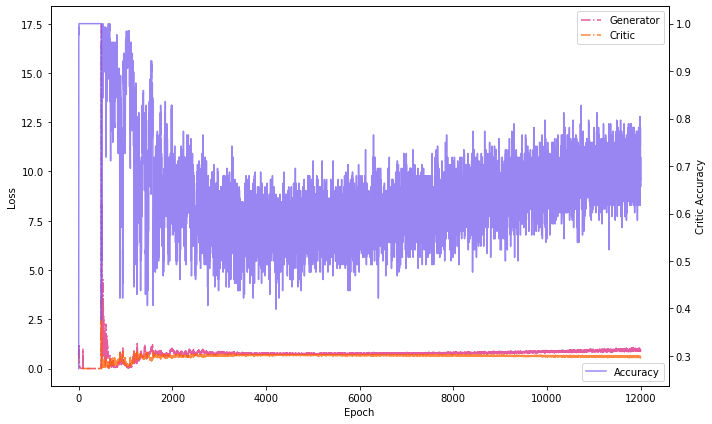

In [7]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(epochs), gloss, '-.', color='#dc267f', alpha=0.75, label='Generator')
ax1.plot(range(epochs), closs, '-.', color='#fe6100', alpha=0.75, label='Critic')
ax1.legend(loc=1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Critic Accuracy')  # we already handled the x-label with ax1
ax2.plot(range(epochs), cacc, color='#785ef0', alpha=0.75, label='Accuracy')
ax2.legend(loc=4)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('ch.14.gan.cnn.mnist.loss.png', dpi=350, bbox_inches='tight')
plt.show()

## Comparing GANs and VAEs

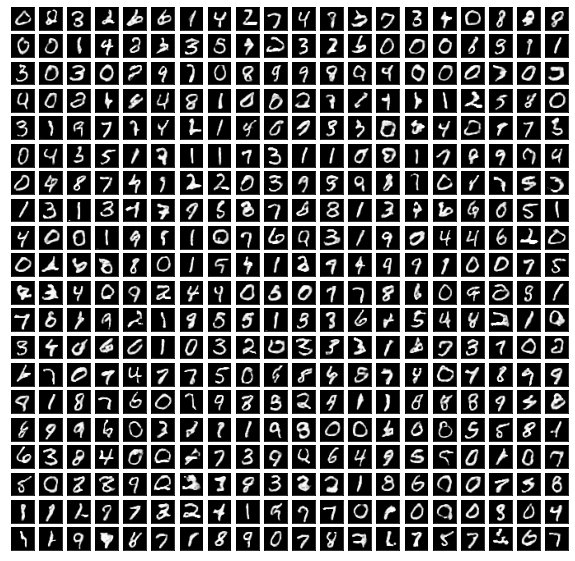

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
cnt = 1
samples = np.random.uniform(0.0, 1.0, size=(400,ltnt_dim))
imgs = generator.predict(samples)
for z1 in np.arange(0.05, 1.05, 0.05):
  for z2 in np.arange(0.05, 1.05, 0.05):
    plt.subplot(20,20,cnt)
    img = imgs[cnt-1]
    plt.imshow(img[:,:,0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    cnt += 1
# plt.savefig('ch.14.gan.cnn.mnist.latent.png', bbox_inches='tight', dpi=350)
plt.show()
